***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- Applying top-down approach. (Coarse-to-Fine)
- Changing the Secondary Capsule Dimension:
    - 8D>12D>16D (Coarse>Medium>FINE)
    - Use Hinge Loss (MarginLoss) for each level + Consistency Loss.
    

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\HD-CapsNet_MOD\Training_and_Analysis\3_CIFAR-10
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "1" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  1
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


## log directory

In [4]:
directory = sysenv.log_dir('3_CIFAR_10/HD_CapsNet/Mod_1_2')

FOLDER CREATED =  ../../logs/MOD_1/3_CIFAR_10/HD_CapsNet/TD_W_C_loss


# Import Dataset : CIFAR-10

In [5]:
dataset = datasets.CIFAR10(version = 'ALL') # importing CIFAR10 Dataset
# dataset = datasets.CIFAR10(version = 'reduce') # importing CIFAR10 Dataset

CIFAR-10 dataset: Training have 50,000 samples and testing have 10,000 samples


# Parameters

In [6]:
train_params = {"n_epochs" : 100,
                "batch_size": 64,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

## Learning Rate Decay Scheduler

In [7]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Bottom up Approach

## Loss Function

In [8]:
number_of_classes_c = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
number_of_classes_m = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
number_of_classes_f = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))

## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": number_of_classes_c,
                                "medium": number_of_classes_m,
                                "fine": number_of_classes_f})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [9]:
coarse_to_medium_array = np.zeros(shape=[number_of_classes_c,number_of_classes_m], dtype=np.int32)
medium_to_fine_array = np.zeros(shape=[number_of_classes_m,number_of_classes_f], dtype=np.int32)

c_id = np.argmax(dataset['y_train_coarse'],1)

m_id = np.argmax(dataset['y_train_medium'],1)

f_id = np.argmax(dataset['y_train_fine'],1)

for x in range(len(dataset['y_test_medium'])):
    coarse_to_medium_array[c_id[x]][m_id[x]] = 1
    
for x in range(len(dataset['y_test_fine'])):
    medium_to_fine_array[m_id[x]][f_id[x]] = 1

Matrix_coarse_to_medium_OneHot = tf.constant(coarse_to_medium_array, dtype=tf.float32)
Matrix_medium_to_fine_OneHot = tf.constant(medium_to_fine_array, dtype=tf.float32)

In [10]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")

    return total_marginloss


def consistency_check(y_pred_ancestor,y_pred_current,lookup_matrix,num_class_current):
    pred_max_ancestor = tf.argmax(y_pred_ancestor,axis=1)
    pred_max_current = tf.argmax(y_pred_current,axis=1)
    
    consistant_check = tf.gather(lookup_matrix, indices=pred_max_ancestor)*tf.one_hot(pred_max_current,num_class_current)
    
    return tf.reduce_sum(consistant_check,1)

def get_consistency(y_true_ancestor, y_pred, lookup_matrix):
    '''
    Get consistency based on 2 levels
    Provide ture levels for the level above, predictions for the current level and a look up metrix
    '''
    y_prob = tf.math.divide(y_pred,tf.reshape(tf.reduce_sum(y_pred,-1),(-1,1),name='reshape'),name='Probability')
    
    index_for_predictions = tf.cast(tf.math.argmax(y_true_ancestor,axis=1),dtype= 'int32')
    consistent_fine = tf.gather(lookup_matrix, indices=index_for_predictions) * y_prob
    Consistency_sum_array = tf.reduce_sum(consistent_fine, axis =1)
    
    return tf.abs(1-Consistency_sum_array)

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F,tree: Tree,C_Weight=0.2):
    
    con_m = consistency_check(y_pred_c,y_pred_m,Matrix_coarse_to_medium_OneHot,num_class_current=7)
    con_m_not = tf.abs(con_m-1)
    
    con_f = consistency_check(y_pred_m,y_pred_f,Matrix_medium_to_fine_OneHot,num_class_current=10)
    con_f_not = tf.abs(con_f-1)
    
    con_sum_m = get_consistency(y_true_c,y_pred_m,Matrix_coarse_to_medium_OneHot)
    con_sum_f = get_consistency(y_true_m,y_pred_f,Matrix_medium_to_fine_OneHot)
    
    medium_lvl_cosistency = con_sum_m * con_m_not
    fine_lvl_cosistency = con_sum_f * con_f_not    
   
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = LW_M*((1-C_Weight)*(margin_loss(y_true_m, y_pred_m))+C_Weight*(medium_lvl_cosistency))
    ML_f = LW_F*((1-C_Weight)*(margin_loss(y_true_f, y_pred_f))+C_Weight*(fine_lvl_cosistency))
    
    batch_loss = ML_c + ML_m+ ML_f

    return tf.reduce_mean(batch_loss)

## Model Architecture

In [11]:
def get_compiled_model():
    input_shape = dataset['x_train'].shape[1:]

    input_shape_yc = dataset['y_train_coarse'].shape[1:]
    input_shape_ym = dataset['y_train_medium'].shape[1:]
    input_shape_yf = dataset['y_train_fine'].shape[1:]

    no_coarse_class = 2
    no_medium_class = 7
    no_fine_class = 10

    PCap_n_dims = 8

    SCap_f_dims = 16
    SCap_m_dims = 12
    SCap_c_dims = 8


    # Input image
    x_input = keras.layers.Input(shape=input_shape, name="Input_Image")

    # Input True Labels
    y_c = keras.layers.Input(shape=input_shape_yc, name='input_yc')
    y_m = keras.layers.Input(shape=input_shape_ym, name='input_ym')
    y_f = keras.layers.Input(shape=input_shape_yf, name='input_yf')

    #--- block 1 ---
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    #--- block 2 ---
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    #--- block 3 ---
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    #--- block 4 ---
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)


    # Layer 3: Reshape to 8D primary capsules 
    # input [batch_size, 6, 6, 512], output [batch_size, 2304, 8]
    reshapec = keras.layers.Reshape((256, PCap_n_dims), name="reshape_layer")(x)
    p_caps = keras.layers.Lambda(models.squash, name='p_caps')(reshapec)

    ## Layer Secondary Capsule: For coarse level
    s_caps_c = models.SecondaryCapsule(n_caps=no_coarse_class, n_dims=SCap_c_dims, 
                        name="s_caps_coarse")(p_caps)
    
    ## Layer Secondary Capsule: For medium level
    s_caps_m = models.SecondaryCapsule(n_caps=no_medium_class, n_dims=SCap_m_dims, 
                        name="s_caps_medium")(s_caps_c)

    ## Layer Secondary Capsule: For fine level
    s_caps_f = models.SecondaryCapsule(n_caps=no_fine_class, n_dims=SCap_f_dims, 
                        name="s_caps_fine")(s_caps_m)

    pred_c = models.LengthLayer(name='prediction_coarse')(s_caps_c)

    pred_m = models.LengthLayer(name='prediction_medium')(s_caps_m)

    pred_f = models.LengthLayer(name='prediction_fine')(s_caps_f)

    model = keras.Model(inputs= [x_input, y_c, y_m, y_f],
                        outputs= [pred_c, pred_m, pred_f],
                        name='HD-CapsNet')

    model.add_loss(CustomLoss(y_c, y_m, y_f, pred_c, pred_m, pred_f, 
                              lossweight['coarse_lw'], lossweight['medium_lw'], lossweight['fine_lw'],
                              dataset['tree']))

    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'
                          }
    )
    return model

In [12]:
model = get_compiled_model()

In [13]:
model.summary()
# keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 32, 32, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 32, 32, 64)   36928       ['batch_normalization[0]

                                                                                                  
 tf.cast (TFOpLambda)           (None,)              0           ['tf.math.argmax_4[0][0]']       
                                                                                                  
 tf.reshape (TFOpLambda)        (None, 1)            0           ['tf.math.reduce_sum_2[0][0]']   
                                                                                                  
 tf.math.argmax (TFOpLambda)    (None,)              0           ['prediction_coarse[0][0]']      
                                                                                                  
 tf.math.argmax_1 (TFOpLambda)  (None,)              0           ['prediction_medium[0][0]']      
                                                                                                  
 tf.math.argmax_5 (TFOpLambda)  (None,)              0           ['input_ym[0][0]']               
          

 da)                                                                                              
                                                                                                  
 tf.math.reduce_sum (TFOpLambda  (None,)             0           ['tf.math.multiply[0][0]']       
 )                                                                                                
                                                                                                  
 tf.math.maximum_4 (TFOpLambda)  (None, 10)          0           ['tf.math.subtract_10[0][0]']    
                                                                                                  
 tf.math.subtract_12 (TFOpLambd  (None, 10)          0           ['input_yf[0][0]']               
 a)                                                                                               
                                                                                                  
 tf.math.m

                                                                                                  
 tf.math.multiply_4 (TFOpLambda  (None,)             0           ['tf.math.abs_2[0][0]',          
 )                                                                'tf.math.abs[0][0]']            
                                                                                                  
 tf.math.add_2 (TFOpLambda)     (None, 10)           0           ['tf.math.multiply_16[0][0]',    
                                                                  'tf.math.multiply_18[0][0]']    
                                                                                                  
 tf.math.abs_3 (TFOpLambda)     (None,)              0           ['tf.math.subtract_3[0][0]']     
                                                                                                  
 tf.math.abs_1 (TFOpLambda)     (None,)              0           ['tf.math.subtract_1[0][0]']     
          

## Data Augmentation

In [14]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1)

training_generator = MixUp_add_loss.MixupGenerator_3level(dataset['x_train'],
                                                 dataset['y_train_coarse'], 
                                                 dataset['y_train_medium'],
                                                 dataset['y_train_fine'],
                                                 batch_size=train_params["batch_size"],
                                                 alpha=0.2, 
                                                 datagen=datagen
                                                )()

## Callback

In [15]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    directory+'/epoch-best.h5', 
    monitor='val_prediction_fine_accuracy',
    save_best_only=True, save_weights_only=True, verbose=1)
change_lw = models.LossWeightsModifier(lossweight = lossweight,
                               initial_lw = initial_lw,
                               directory = directory)
lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [16]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'],
                                            dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    model.save_weights(model_save_dir)

Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 0.3513 - prediction_coarse_accuracy: 0.8317 - prediction_medium_accuracy: 0.3370 - prediction_fine_accuracy: 0.1595
  • Coarse Accuracy = 83.17% | Val_Accuracy = 85.23% | LossWeight = 0.16 
  • Medium Accuracy = 33.70% | Val_Accuracy = 42.94% | LossWeight = 0.43 
  • Fine   Accuracy = 15.95% | Val_Accuracy = 23.84% | LossWeight = 0.41 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.23840, saving model to ../../logs/MOD_1/3_CIFAR_10/HD_CapsNet/TD_W_C_loss\epoch-best.h5
781/781 [==============================] - 50s 54ms/step - loss: 0.3513 - prediction_coarse_accuracy: 0.8317 - prediction_medium_accuracy: 0.3370 - prediction_fine_accuracy: 0.1595 - val_loss: 0.2405 - val_prediction_coarse_accuracy: 0.8523 - val_prediction_medium_accuracy: 0.4294 - val_prediction_fine_accuracy: 0.2384 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 0.2133 - prediction_coarse_accuracy

781/781 [==============================] - 41s 52ms/step - loss: 0.1107 - prediction_coarse_accuracy: 0.9397 - prediction_medium_accuracy: 0.7835 - prediction_fine_accuracy: 0.6856 - val_loss: 0.0772 - val_prediction_coarse_accuracy: 0.9619 - val_prediction_medium_accuracy: 0.8176 - val_prediction_fine_accuracy: 0.7145 - lr: 0.0010
Epoch 10/100
781/781 [==============================] - ETA: 0s - loss: 0.1042 - prediction_coarse_accuracy: 0.9432 - prediction_medium_accuracy: 0.8030 - prediction_fine_accuracy: 0.7178
  • Coarse Accuracy = 94.32% | Val_Accuracy = 96.00% | LossWeight = 0.16 
  • Medium Accuracy = 80.30% | Val_Accuracy = 83.13% | LossWeight = 0.40 
  • Fine   Accuracy = 71.78% | Val_Accuracy = 75.08% | LossWeight = 0.43 

Epoch 10: val_prediction_fine_accuracy improved from 0.71450 to 0.75080, saving model to ../../logs/MOD_1/3_CIFAR_10/HD_CapsNet/TD_W_C_loss\epoch-best.h5
781/781 [==============================] - 40s 52ms/step - loss: 0.1042 - prediction_coarse_accuracy:

781/781 [==============================] - 41s 52ms/step - loss: 0.0701 - prediction_coarse_accuracy: 0.9703 - prediction_medium_accuracy: 0.9032 - prediction_fine_accuracy: 0.8519 - val_loss: 0.0486 - val_prediction_coarse_accuracy: 0.9756 - val_prediction_medium_accuracy: 0.8852 - val_prediction_fine_accuracy: 0.8329 - lr: 6.6342e-04
Epoch 19/100
781/781 [==============================] - ETA: 0s - loss: 0.0683 - prediction_coarse_accuracy: 0.9713 - prediction_medium_accuracy: 0.9081 - prediction_fine_accuracy: 0.8594
  • Coarse Accuracy = 97.13% | Val_Accuracy = 97.56% | LossWeight = 0.17 
  • Medium Accuracy = 90.81% | Val_Accuracy = 87.95% | LossWeight = 0.39 
  • Fine   Accuracy = 85.94% | Val_Accuracy = 83.21% | LossWeight = 0.44 

Epoch 19: val_prediction_fine_accuracy did not improve from 0.83290
781/781 [==============================] - 40s 51ms/step - loss: 0.0683 - prediction_coarse_accuracy: 0.9713 - prediction_medium_accuracy: 0.9081 - prediction_fine_accuracy: 0.8594 - 

781/781 [==============================] - 41s 52ms/step - loss: 0.0582 - prediction_coarse_accuracy: 0.9780 - prediction_medium_accuracy: 0.9370 - prediction_fine_accuracy: 0.9055 - val_loss: 0.0425 - val_prediction_coarse_accuracy: 0.9795 - val_prediction_medium_accuracy: 0.9014 - val_prediction_fine_accuracy: 0.8560 - lr: 4.1812e-04
Epoch 28/100
781/781 [==============================] - ETA: 0s - loss: 0.0572 - prediction_coarse_accuracy: 0.9780 - prediction_medium_accuracy: 0.9400 - prediction_fine_accuracy: 0.9093
  • Coarse Accuracy = 97.80% | Val_Accuracy = 97.90% | LossWeight = 0.20 
  • Medium Accuracy = 94.00% | Val_Accuracy = 89.55% | LossWeight = 0.38 
  • Fine   Accuracy = 90.93% | Val_Accuracy = 85.36% | LossWeight = 0.43 

Epoch 28: val_prediction_fine_accuracy did not improve from 0.85600
781/781 [==============================] - 40s 52ms/step - loss: 0.0572 - prediction_coarse_accuracy: 0.9780 - prediction_medium_accuracy: 0.9400 - prediction_fine_accuracy: 0.9093 - 

781/781 [==============================] - 41s 52ms/step - loss: 0.0534 - prediction_coarse_accuracy: 0.9809 - prediction_medium_accuracy: 0.9499 - prediction_fine_accuracy: 0.9295 - val_loss: 0.0396 - val_prediction_coarse_accuracy: 0.9823 - val_prediction_medium_accuracy: 0.9083 - val_prediction_fine_accuracy: 0.8689 - lr: 2.6352e-04
Epoch 37/100
780/781 [============================>.] - ETA: 0s - loss: 0.0521 - prediction_coarse_accuracy: 0.9816 - prediction_medium_accuracy: 0.9516 - prediction_fine_accuracy: 0.9334
  • Coarse Accuracy = 98.17% | Val_Accuracy = 98.20% | LossWeight = 0.21 
  • Medium Accuracy = 95.17% | Val_Accuracy = 90.87% | LossWeight = 0.39 
  • Fine   Accuracy = 93.35% | Val_Accuracy = 86.93% | LossWeight = 0.40 

Epoch 37: val_prediction_fine_accuracy improved from 0.86890 to 0.86930, saving model to ../../logs/MOD_1/3_CIFAR_10/HD_CapsNet/TD_W_C_loss\epoch-best.h5
781/781 [==============================] - 41s 52ms/step - loss: 0.0521 - prediction_coarse_accur

Epoch 46/100
780/781 [============================>.] - ETA: 0s - loss: 0.0507 - prediction_coarse_accuracy: 0.9826 - prediction_medium_accuracy: 0.9573 - prediction_fine_accuracy: 0.9428
  • Coarse Accuracy = 98.26% | Val_Accuracy = 98.13% | LossWeight = 0.22 
  • Medium Accuracy = 95.74% | Val_Accuracy = 90.97% | LossWeight = 0.39 
  • Fine   Accuracy = 94.29% | Val_Accuracy = 86.98% | LossWeight = 0.39 

Epoch 46: val_prediction_fine_accuracy did not improve from 0.87120
781/781 [==============================] - 40s 52ms/step - loss: 0.0507 - prediction_coarse_accuracy: 0.9826 - prediction_medium_accuracy: 0.9574 - prediction_fine_accuracy: 0.9429 - val_loss: 0.0396 - val_prediction_coarse_accuracy: 0.9813 - val_prediction_medium_accuracy: 0.9097 - val_prediction_fine_accuracy: 0.8698 - lr: 1.5778e-04
Epoch 47/100
781/781 [==============================] - ETA: 0s - loss: 0.0506 - prediction_coarse_accuracy: 0.9814 - prediction_medium_accuracy: 0.9554 - prediction_fine_accuracy: 0.

781/781 [==============================] - 41s 53ms/step - loss: 0.0491 - prediction_coarse_accuracy: 0.9841 - prediction_medium_accuracy: 0.9610 - prediction_fine_accuracy: 0.9508 - val_loss: 0.0371 - val_prediction_coarse_accuracy: 0.9832 - val_prediction_medium_accuracy: 0.9143 - val_prediction_fine_accuracy: 0.8765 - lr: 6.2672e-05
Epoch 65/100
781/781 [==============================] - ETA: 0s - loss: 0.0490 - prediction_coarse_accuracy: 0.9835 - prediction_medium_accuracy: 0.9607 - prediction_fine_accuracy: 0.9509
  • Coarse Accuracy = 98.35% | Val_Accuracy = 98.25% | LossWeight = 0.24 
  • Medium Accuracy = 96.07% | Val_Accuracy = 91.60% | LossWeight = 0.39 
  • Fine   Accuracy = 95.09% | Val_Accuracy = 87.60% | LossWeight = 0.37 

Epoch 65: val_prediction_fine_accuracy did not improve from 0.87660
781/781 [==============================] - 41s 53ms/step - loss: 0.0490 - prediction_coarse_accuracy: 0.9835 - prediction_medium_accuracy: 0.9607 - prediction_fine_accuracy: 0.9509 - 

Epoch 74/100
780/781 [============================>.] - ETA: 0s - loss: 0.0488 - prediction_coarse_accuracy: 0.9837 - prediction_medium_accuracy: 0.9603 - prediction_fine_accuracy: 0.9508
  • Coarse Accuracy = 98.37% | Val_Accuracy = 98.31% | LossWeight = 0.23 
  • Medium Accuracy = 96.03% | Val_Accuracy = 91.66% | LossWeight = 0.40 
  • Fine   Accuracy = 95.08% | Val_Accuracy = 87.88% | LossWeight = 0.37 

Epoch 74: val_prediction_fine_accuracy did not improve from 0.87880
781/781 [==============================] - 41s 53ms/step - loss: 0.0488 - prediction_coarse_accuracy: 0.9837 - prediction_medium_accuracy: 0.9603 - prediction_fine_accuracy: 0.9508 - val_loss: 0.0368 - val_prediction_coarse_accuracy: 0.9831 - val_prediction_medium_accuracy: 0.9166 - val_prediction_fine_accuracy: 0.8788 - lr: 3.7524e-05
Epoch 75/100
781/781 [==============================] - ETA: 0s - loss: 0.0483 - prediction_coarse_accuracy: 0.9835 - prediction_medium_accuracy: 0.9613 - prediction_fine_accuracy: 0.

781/781 [==============================] - 45s 58ms/step - loss: 0.0484 - prediction_coarse_accuracy: 0.9834 - prediction_medium_accuracy: 0.9599 - prediction_fine_accuracy: 0.9513 - val_loss: 0.0364 - val_prediction_coarse_accuracy: 0.9820 - val_prediction_medium_accuracy: 0.9177 - val_prediction_fine_accuracy: 0.8793 - lr: 2.3650e-05
Epoch 84/100
781/781 [==============================] - ETA: 0s - loss: 0.0485 - prediction_coarse_accuracy: 0.9843 - prediction_medium_accuracy: 0.9604 - prediction_fine_accuracy: 0.9513
  • Coarse Accuracy = 98.43% | Val_Accuracy = 98.23% | LossWeight = 0.23 
  • Medium Accuracy = 96.04% | Val_Accuracy = 91.69% | LossWeight = 0.40 
  • Fine   Accuracy = 95.13% | Val_Accuracy = 87.92% | LossWeight = 0.37 

Epoch 84: val_prediction_fine_accuracy did not improve from 0.87980
781/781 [==============================] - 45s 57ms/step - loss: 0.0485 - prediction_coarse_accuracy: 0.9843 - prediction_medium_accuracy: 0.9604 - prediction_fine_accuracy: 0.9513 - 

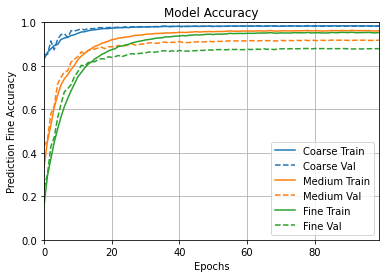

In [17]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])

except:
    print('Trained model weights loaded')

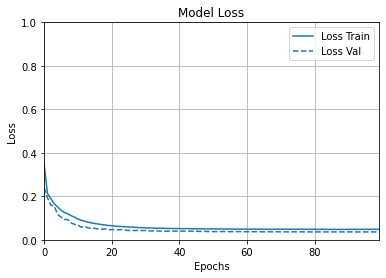

In [18]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])

except:
    print('Trained model weights loaded')

## Model Analysis

In [19]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 6s 14ms/step - loss: 0.0599 - prediction_coarse_loss: 0.0142 - prediction_medium_loss: 0.0605 - prediction_fine_loss: 0.0889 - prediction_coarse_accuracy: 0.9824 - prediction_medium_accuracy: 0.9183 - prediction_fine_accuracy: 0.8789
1. loss ==> 0.05992600694298744
2. prediction_coarse_loss ==> 0.01421485748142004
3. prediction_medium_loss ==> 0.06047825887799263
4. prediction_fine_loss ==> 0.08891066163778305
5. prediction_coarse_accuracy ==> 0.9824000000953674
6. prediction_medium_accuracy ==> 0.9182999730110168
7. prediction_fine_accuracy ==> 0.8788999915122986
313/313 [==============================] - 4s 9ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

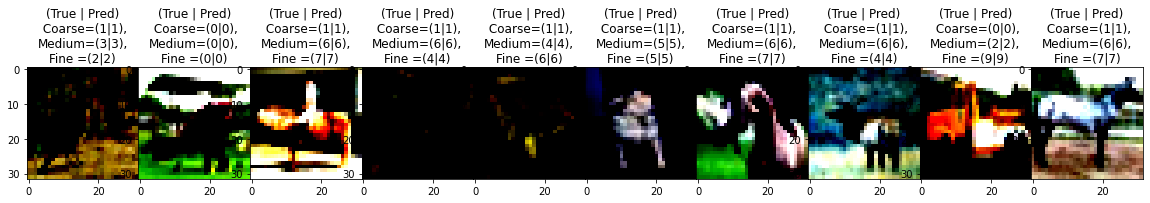

In [20]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[3923   77]
 [  99 5901]]

  • MEDIUM LEVEL 
[[ 919   15   24   20    4   10    8]
 [  31  923   28    0    3    9    6]
 [  13   12 1966    1    2    5    1]
 [  31    4    5  831   30   55   44]
 [   4    1    3   16  934   36    6]
 [   9    9   18   39   48 1789   88]
 [  15    3    8   40   31   82 1821]]

  • FINE LEVEL 
[[921  10  19  15   1   0   2   4  16  12]
 [  3 947   0   2   0   0   0   0   6  42]
 [ 36   1 832  31  28  20  33  13   3   3]
 [  5   2  31 754  28 108  40  17   6   9]
 [  6   1  32  28 858  16  32  25   2   0]
 [  6   1  25 130  21 787  11  15   0   4]
 [  5   1  15  32   4   6 933   1   1   2]
 [  5   0  14  19  25  25   3 900   1   8]
 [ 31  10   1   9   3   1   3   3 924  15]
 [  8  38   1   7   0   0   3   1   9 933]]

  • Classification Report 


  • COARSE LEVEL 


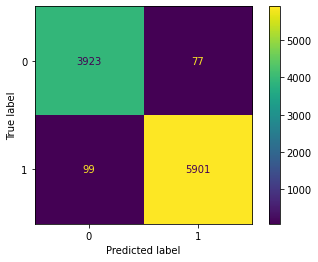

              precision    recall  f1-score   support

           0    0.97539   0.98075   0.97806      4000
           1    0.98712   0.98350   0.98531      6000

    accuracy                        0.98240     10000
   macro avg    0.98125   0.98213   0.98168     10000
weighted avg    0.98243   0.98240   0.98241     10000


  • MEDIUM LEVEL 


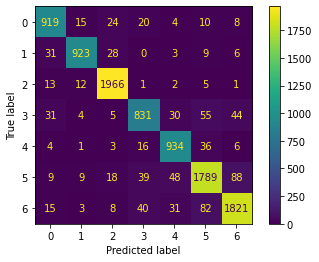

              precision    recall  f1-score   support

           0    0.89922   0.91900   0.90900      1000
           1    0.95450   0.92300   0.93849      1000
           2    0.95809   0.98300   0.97038      2000
           3    0.87751   0.83100   0.85362      1000
           4    0.88783   0.93400   0.91033      1000
           5    0.90081   0.89450   0.89764      2000
           6    0.92249   0.91050   0.91646      2000

    accuracy                        0.91830     10000
   macro avg    0.91435   0.91357   0.91370     10000
weighted avg    0.91818   0.91830   0.91804     10000


  • FINE LEVEL 


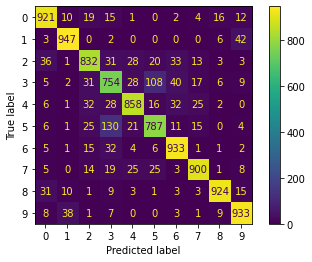

              precision    recall  f1-score   support

           0    0.89766   0.92100   0.90918      1000
           1    0.93670   0.94700   0.94182      1000
           2    0.85773   0.83200   0.84467      1000
           3    0.73418   0.75400   0.74396      1000
           4    0.88636   0.85800   0.87195      1000
           5    0.81724   0.78700   0.80183      1000
           6    0.88019   0.93300   0.90583      1000
           7    0.91931   0.90000   0.90955      1000
           8    0.95455   0.92400   0.93902      1000
           9    0.90759   0.93300   0.92012      1000

    accuracy                        0.87890     10000
   macro avg    0.87915   0.87890   0.87879     10000
weighted avg    0.87915   0.87890   0.87879     10000



In [21]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [22]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.9257033333333333 
Hierarchical Recall = 0.9286333333333332 
Hierarchical F1-Score = 0.9269119047619048 
Consistency =  0.9846 
Exact Match =  0.8742
